# 

**Импортирую библиотеки**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PolynomialFeatures,LabelEncoder, MaxAbsScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy import stats
from prettytable import PrettyTable
from sklearn.ensemble import RandomForestClassifier

In [4]:
train = pd.read_csv(r"C:\Users\lemes\Downloads\train.csv")

In [5]:
train.describe(include = 'object').T

,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Gollux Reedall,2


In [6]:
train.describe(include = [np.number]).T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [7]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Нули

In [9]:
nan_counts = train.isnull().sum()
nan_percentage = (train.isnull().sum()/len(train))*100
nan_sum = pd.DataFrame({'NaN_Count':nan_counts, 'NaN_Percentage':nan_percentage}).sort_values(by='NaN_Count',ascending=False)
nan_sum[nan_sum['NaN_Count'] > 0]

,NaN_Count,NaN_Percentage
CryoSleep,217,2.496261
ShoppingMall,208,2.392730
VIP,203,2.335212
HomePlanet,201,2.312205
Name,200,2.300702
Cabin,199,2.289198
VRDeck,188,2.162660
FoodCourt,183,2.105142
Spa,183,2.105142
Destination,182,2.093639


Создаю новый столбец с группами пассажиров из столбца их Id

In [11]:
def pass_id(df):
    df[['PassengerGroup','PassengerId']] = df['PassengerId'].str.split('_',expand=True)
    
    return df

Создаю новые столбцы Deck, Num, Side из столбца Cabin

In [13]:
def cabin(df): 
    df[['Deck','Num','Side']] = df['Cabin'].str.split('/',expand=True)
    return df

Привожу нужные столбцы к boolean типу

In [15]:
def to_bool(df):
    df['VIP'] = df['VIP'].astype("boolean")
    df['CryoSleep'] = df['CryoSleep'].astype("boolean")
    
    return df

Применяю все функции до и удаляю столбцы Имени и Кабины

In [17]:
def conv(df):
    df = pass_id(df)
    df = to_bool(df)
    df = cabin(df)
    df= df.drop(columns=['Name','Cabin'])
    return df

Денежные значения заполняю нулями где нужно, создаю новый столбец с суммой потраченных денег на пассажира, значения VIP заполняю наиболее частым False, CryoSleep заполняю True, если пассажир что либо покупал, иначе False

Значения столбцов Deck, Side, Destination, HomePlanet заполняю модой по группе их пассажиров, если они одни - заполняю модой по всему столбцу. Num заполняю просто его модой. Age заполняю средним

In [20]:
def null_group(df):
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Age'] = df['Age'].astype(int)
    df['Deck'] = df.groupby('PassengerGroup')['Deck'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
    df['Side'] = df.groupby('PassengerGroup')['Side'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
    df['Num'] = df['Num'].fillna(df['Num'].mode()[0])
    df['Destination'] = df.groupby('PassengerGroup')['Destination'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
    df['HomePlanet'] = df.groupby('PassengerGroup')['HomePlanet'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
    df['Num'] = df['Num'].fillna(df['Num'].mode()[0])
    df['Deck'] = df['Deck'].fillna(df['Deck'].mode()[0])
    df['Side'] = df['Side'].fillna(df['Side'].mode()[0])
    df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])
    df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
    df['RoomService'] = df['RoomService'].fillna(0)
    df['RoomService'] = df['RoomService'].astype(float)
    df['FoodCourt'] = df['FoodCourt'].fillna(0)
    df['FoodCourt'] = df['FoodCourt'].astype(float)
    df['ShoppingMall'] = df['ShoppingMall'].fillna(0)
    df['ShoppingMall'] = df['ShoppingMall'].astype(float)
    df['Spa'] = df['Spa'].fillna(0)
    df['Spa'] = df['Spa'].astype(float)
    df['VRDeck'] = df['VRDeck'].fillna(0)
    df['VRDeck'] = df['VRDeck'].astype(float)
    df['TotalBill'] = df['RoomService']+ df['FoodCourt']+ df['ShoppingMall']+ df['Spa']+ df['VRDeck']
    df['VIP'] = df['VIP'].fillna(False)
    df['CryoSleep'] = np.where(df['CryoSleep'].isna(),df['TotalBill'] == 0, df['CryoSleep'])
    return df

Биннинг по возрасту

In [22]:
def age(df):
    df['AgeGroup'] = pd.qcut(df['Age'], q = 4, labels=['Baby','Young','Middle','Old'])
    return df

In [23]:
def agecount(df):
    y_m = df[df['AgeGroup'].isin(['Baby'])]
    count_by_group = y_m.groupby('PassengerGroup').size()
    df['AgeCount'] = df['PassengerGroup'].map(count_by_group).fillna(0).astype(int)
    return df

In [24]:
def null_out(df):
    df = null_group(df)
    df = age(df)
    df = agecount(df)
    return df

In [25]:
def met(df):
    df = conv(df)
    df = null_out(df)
    return df

In [26]:
train = met(train)

In [27]:
train.nunique()

PassengerId          8
HomePlanet           3
CryoSleep            2
Destination          3
Age                 80
VIP                  2
RoomService       1273
FoodCourt         1507
ShoppingMall      1115
Spa               1327
VRDeck            1306
Transported          2
PassengerGroup    6217
Deck                 8
Num               1817
Side                 2
TotalBill         2336
AgeGroup             4
AgeCount             7
dtype: int64

In [28]:
nan_counts = train.isnull().sum()
nan_percentage = (train.isnull().sum()/len(train))*100
nan_sum = pd.DataFrame({'NaN_Count':nan_counts, 'NaN_Percentage':nan_percentage}).sort_values(by='NaN_Count',ascending=False)
nan_sum

,NaN_Count,NaN_Percentage
PassengerId,0,0.0
VRDeck,0,0.0
AgeGroup,0,0.0
TotalBill,0,0.0
Side,0,0.0
Num,0,0.0
Deck,0,0.0
PassengerGroup,0,0.0
Transported,0,0.0
Spa,0,0.0


In [29]:
train.groupby('Transported')['Transported'].count()

Transported
False    4315
True     4378
Name: Transported, dtype: int64

In [30]:
corr = train.drop(columns=['Deck', 'Num','Side', 'HomePlanet', 'Destination','AgeGroup','PassengerGroup','PassengerId']).corr()

<Axes: >

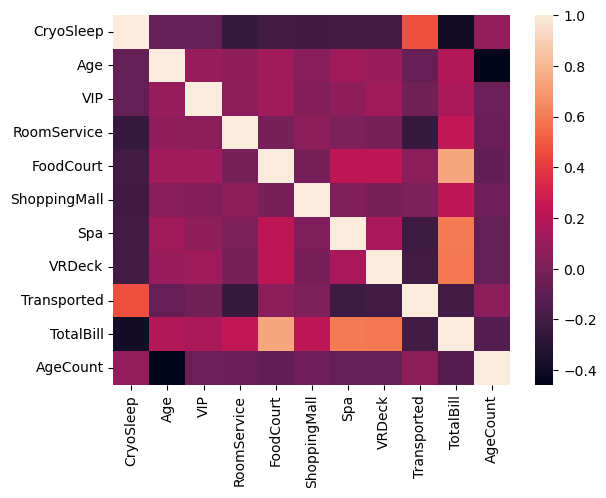

In [31]:
sns.heatmap(corr)

Смотрю на значения в категориальных признаках

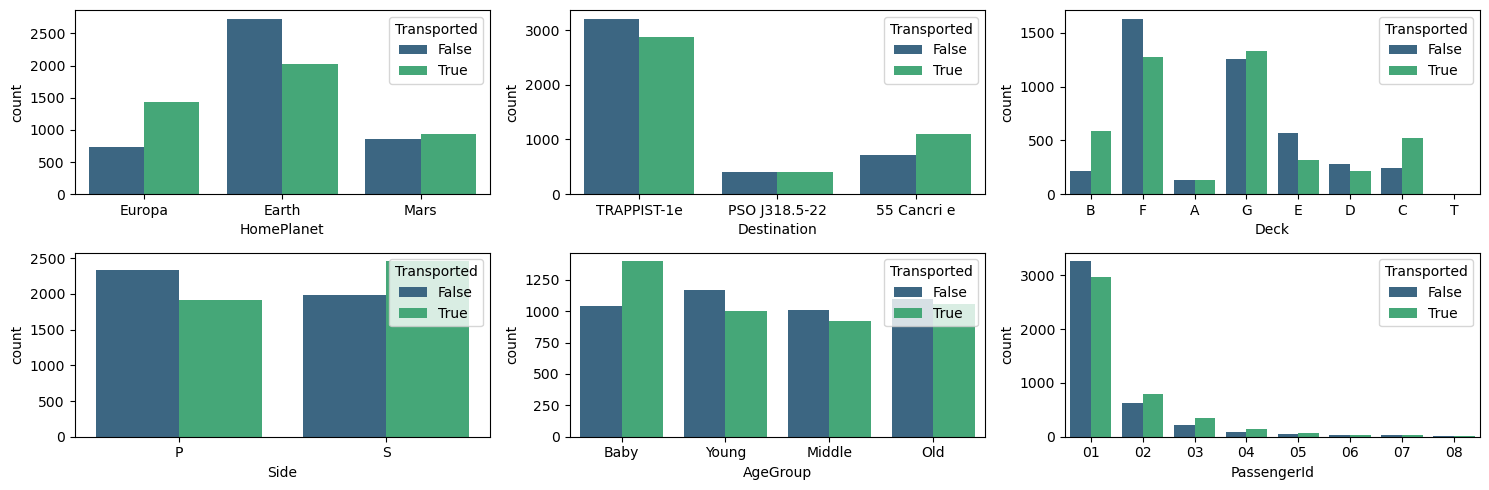

In [33]:
cat = ['HomePlanet','Destination','Deck','Side','AgeGroup','PassengerId']
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
for i, col in enumerate(cat):
    k = i% 3
    j = i // 3
    value_counts = train[col].value_counts()
    sns.countplot(data=train, x=col, ax=axes[j,k],hue='Transported',palette='viridis')

plt.tight_layout()
plt.show()

Группирую большие вариации значений с большой уникальностью

In [35]:
train['Num'] = pd.cut(train['Num'].astype(int),bins=5,labels=[1,2,3,4,5])
train['PassengerId'] = pd.cut(train['PassengerId'].astype(int),bins=4,labels=[1,2,3,4])
train['PassengerGroup'] = pd.cut(train['PassengerGroup'].astype(int),bins=4,labels=[1,2,3,4])

Смотрю на графики оставшихся значений

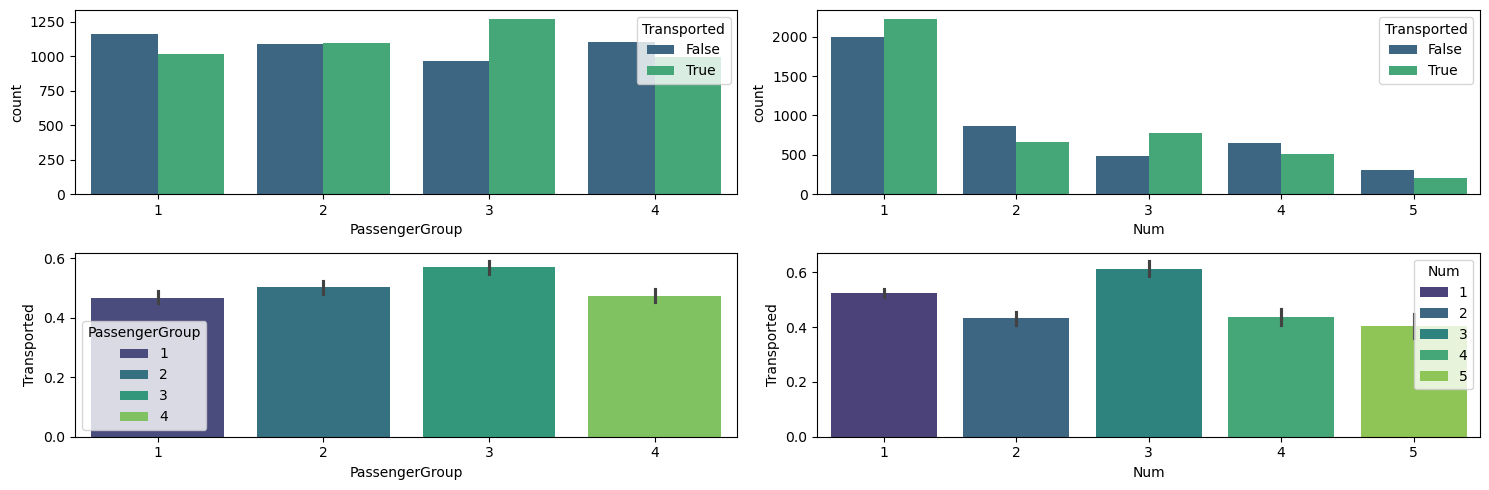

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
un_cat = ['PassengerGroup','Num']
for i, col in enumerate(un_cat):
    k = i% 2
    value_counts = train[col].value_counts()
    sns.countplot(data=train, x=col, ax=axes[0,k],hue='Transported',palette='viridis')
    sns.barplot(data=train,x=col,y='Transported',ax=axes[1,k],hue=col,palette='viridis')

plt.tight_layout()
plt.show()

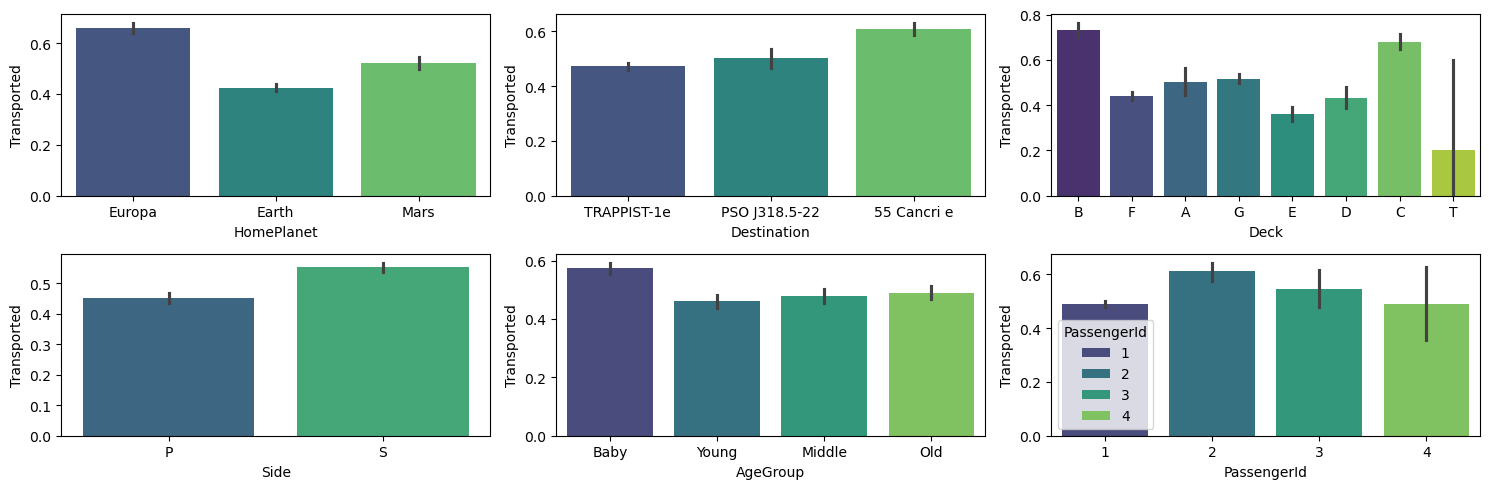

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
for i, col in enumerate(cat):
    k = i% 3
    j = i // 3
    value_counts = train[col].value_counts()
    sns.barplot(data=train, x=col,y='Transported', ax=axes[j,k], hue=col,palette='viridis')

plt.tight_layout()
plt.show()

Гистограммы для числовых признаков

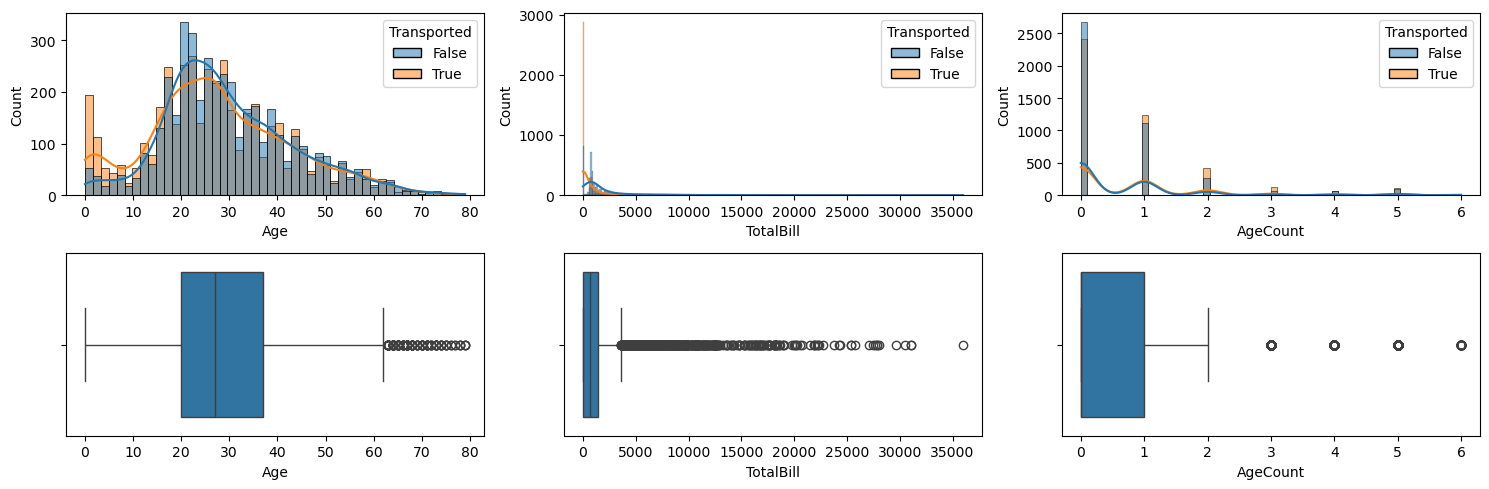

In [40]:
numb = ['Age','TotalBill','AgeCount']
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
for i, col in enumerate(numb):
    k = i% 3
    value_counts = train[col].value_counts()
    sns.histplot(data=train, x=col, hue='Transported', kde=True, ax=axes[0,k])
    sns.boxplot(data=train,x=col,ax=axes[1,k])
    

plt.tight_layout()
plt.show()

от 20до40 где то по большей части не перемещаются, а от 0 до 20 наоборот

Колонки трат

In [43]:
total_cols = ['FoodCourt','RoomService','ShoppingMall','Spa','VRDeck','TotalBill']
for col in total_cols:
    zero_count = (train[col] == 0).sum()
    percentage_zero = (zero_count/len(train[col]))*100
    mean_zero = train['Transported'][train[col] == 0].mean()
    print(col)
    print(f"Количество нулевых:{zero_count}  Процент:{percentage_zero}%  Среднее:{mean_zero}")
    print('-'*100)

    

FoodCourt
Количество нулевых:5639  Процент:64.86828482687218%  Среднее:0.5892888810072708
----------------------------------------------------------------------------------------------------
RoomService
Количество нулевых:5758  Процент:66.23720234671575%  Среднее:0.6278221604723863
----------------------------------------------------------------------------------------------------
ShoppingMall
Количество нулевых:5795  Процент:66.66283216380997%  Среднее:0.5968938740293356
----------------------------------------------------------------------------------------------------
Spa
Количество нулевых:5507  Процент:63.34982169561716%  Среднее:0.6344652260759034
----------------------------------------------------------------------------------------------------
VRDeck
Количество нулевых:5683  Процент:65.3744392039572%  Среднее:0.6244941052261129
----------------------------------------------------------------------------------------------------
TotalBill
Количество нулевых:3653  Процент:42.0223

Их гистограммы

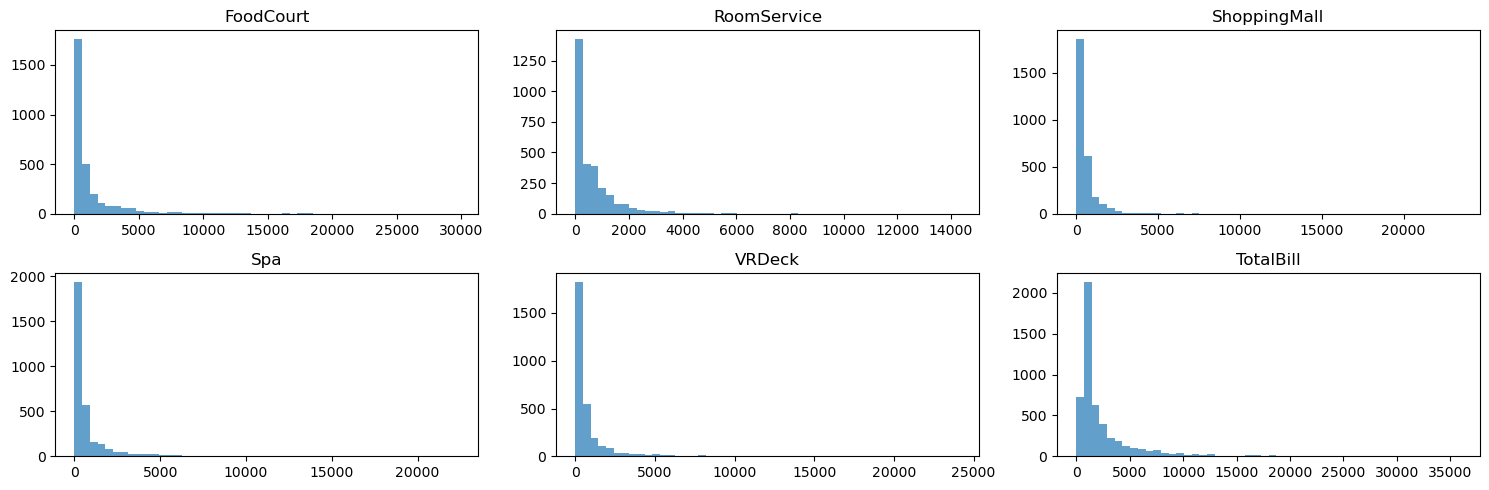

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
for i,col in enumerate(total_cols):
    new_df = train[train[col] != 0]
    k = i % 3
    j = i // 3
    axes[j,k].hist(new_df[col],bins=50,alpha=0.7)
    axes[j,k].set_title(col)

plt.tight_layout()
plt.show()

C:\Users\lemes\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


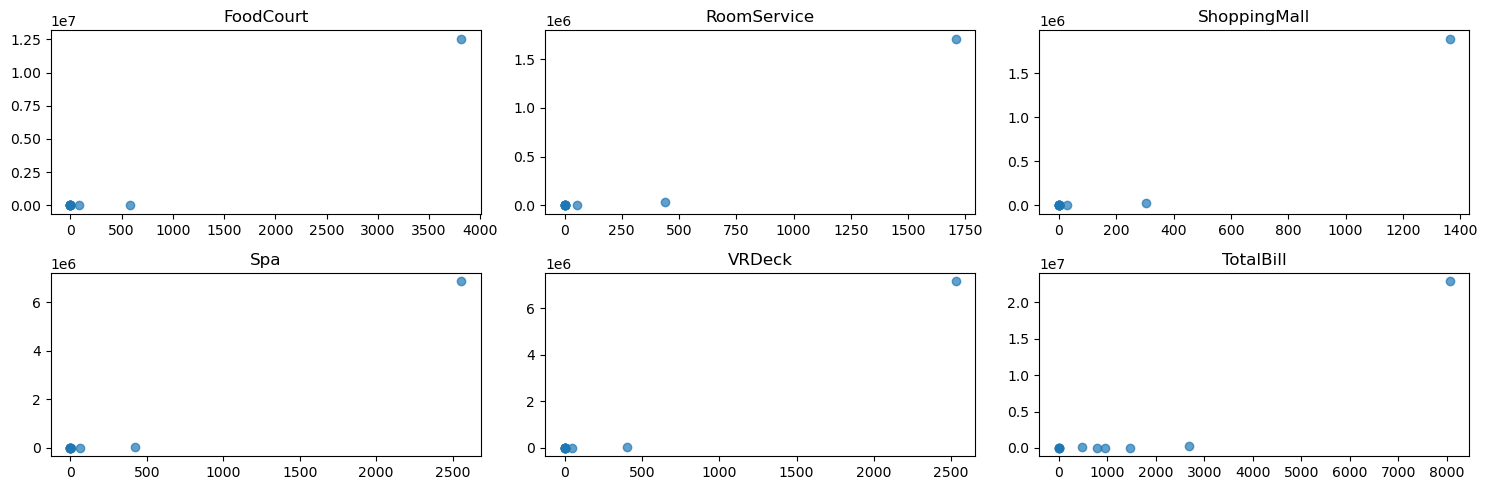

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
for i,col in enumerate(total_cols):
    new_df = train[train[col] != 0]
    k = i % 3
    j = i // 3
    bins = np.array_split(train.sort_values(col),10)
    means = [bin[col].mean() for bin in bins]
    variances = [bin[col].var() for bin in bins]
    axes[j,k].scatter(means,variances,alpha=0.7)
    axes[j,k].set_title(col)

plt.tight_layout()
plt.show()

In [47]:

def group_bool(df):
    l = []
    for col in total_cols:
        df[col],lambdaa = stats.boxcox(df[col]+1)
        l.append(lambdaa)
    return df
#train = group_bool(train)
#test = group_bool(test)

In [48]:
train.nunique()

PassengerId          4
HomePlanet           3
CryoSleep            2
Destination          3
Age                 80
VIP                  2
RoomService       1273
FoodCourt         1507
ShoppingMall      1115
Spa               1327
VRDeck            1306
Transported          2
PassengerGroup       4
Deck                 8
Num                  5
Side                 2
TotalBill         2336
AgeGroup             4
AgeCount             7
dtype: int64

In [49]:

def ttest(train, feature_list, target):
    ttest_results = []
    
    for feature in feature_list:
        group_0 = train[train[target] == 0][feature]
        group_1 = train[train[target] == 1][feature]
        
        t_stat, p_val = stats.ttest_ind(group_0, group_1, nan_policy='omit')
        
        ttest_results.append({'feature':feature,
                             't_stat':t_stat,
                              'p_value':p_val
                            })
    tt_df = pd.DataFrame(ttest_results)
    return tt_df.set_index('feature')

In [50]:
num = train.select_dtypes(include=[np.number]).columns
ttest(train,num,'Transported')

,t_stat,p_value
feature,,
Age,6.939519,4.216286e-12
RoomService,23.162291,3.205394e-115
FoodCourt,-4.253960,2.122241e-05
ShoppingMall,-0.875522,3.813140e-01
Spa,20.878640,1.701990e-94
VRDeck,19.513368,4.969701e-83
TotalBill,18.981445,9.382847e-79
AgeCount,-5.596426,2.254625e-08


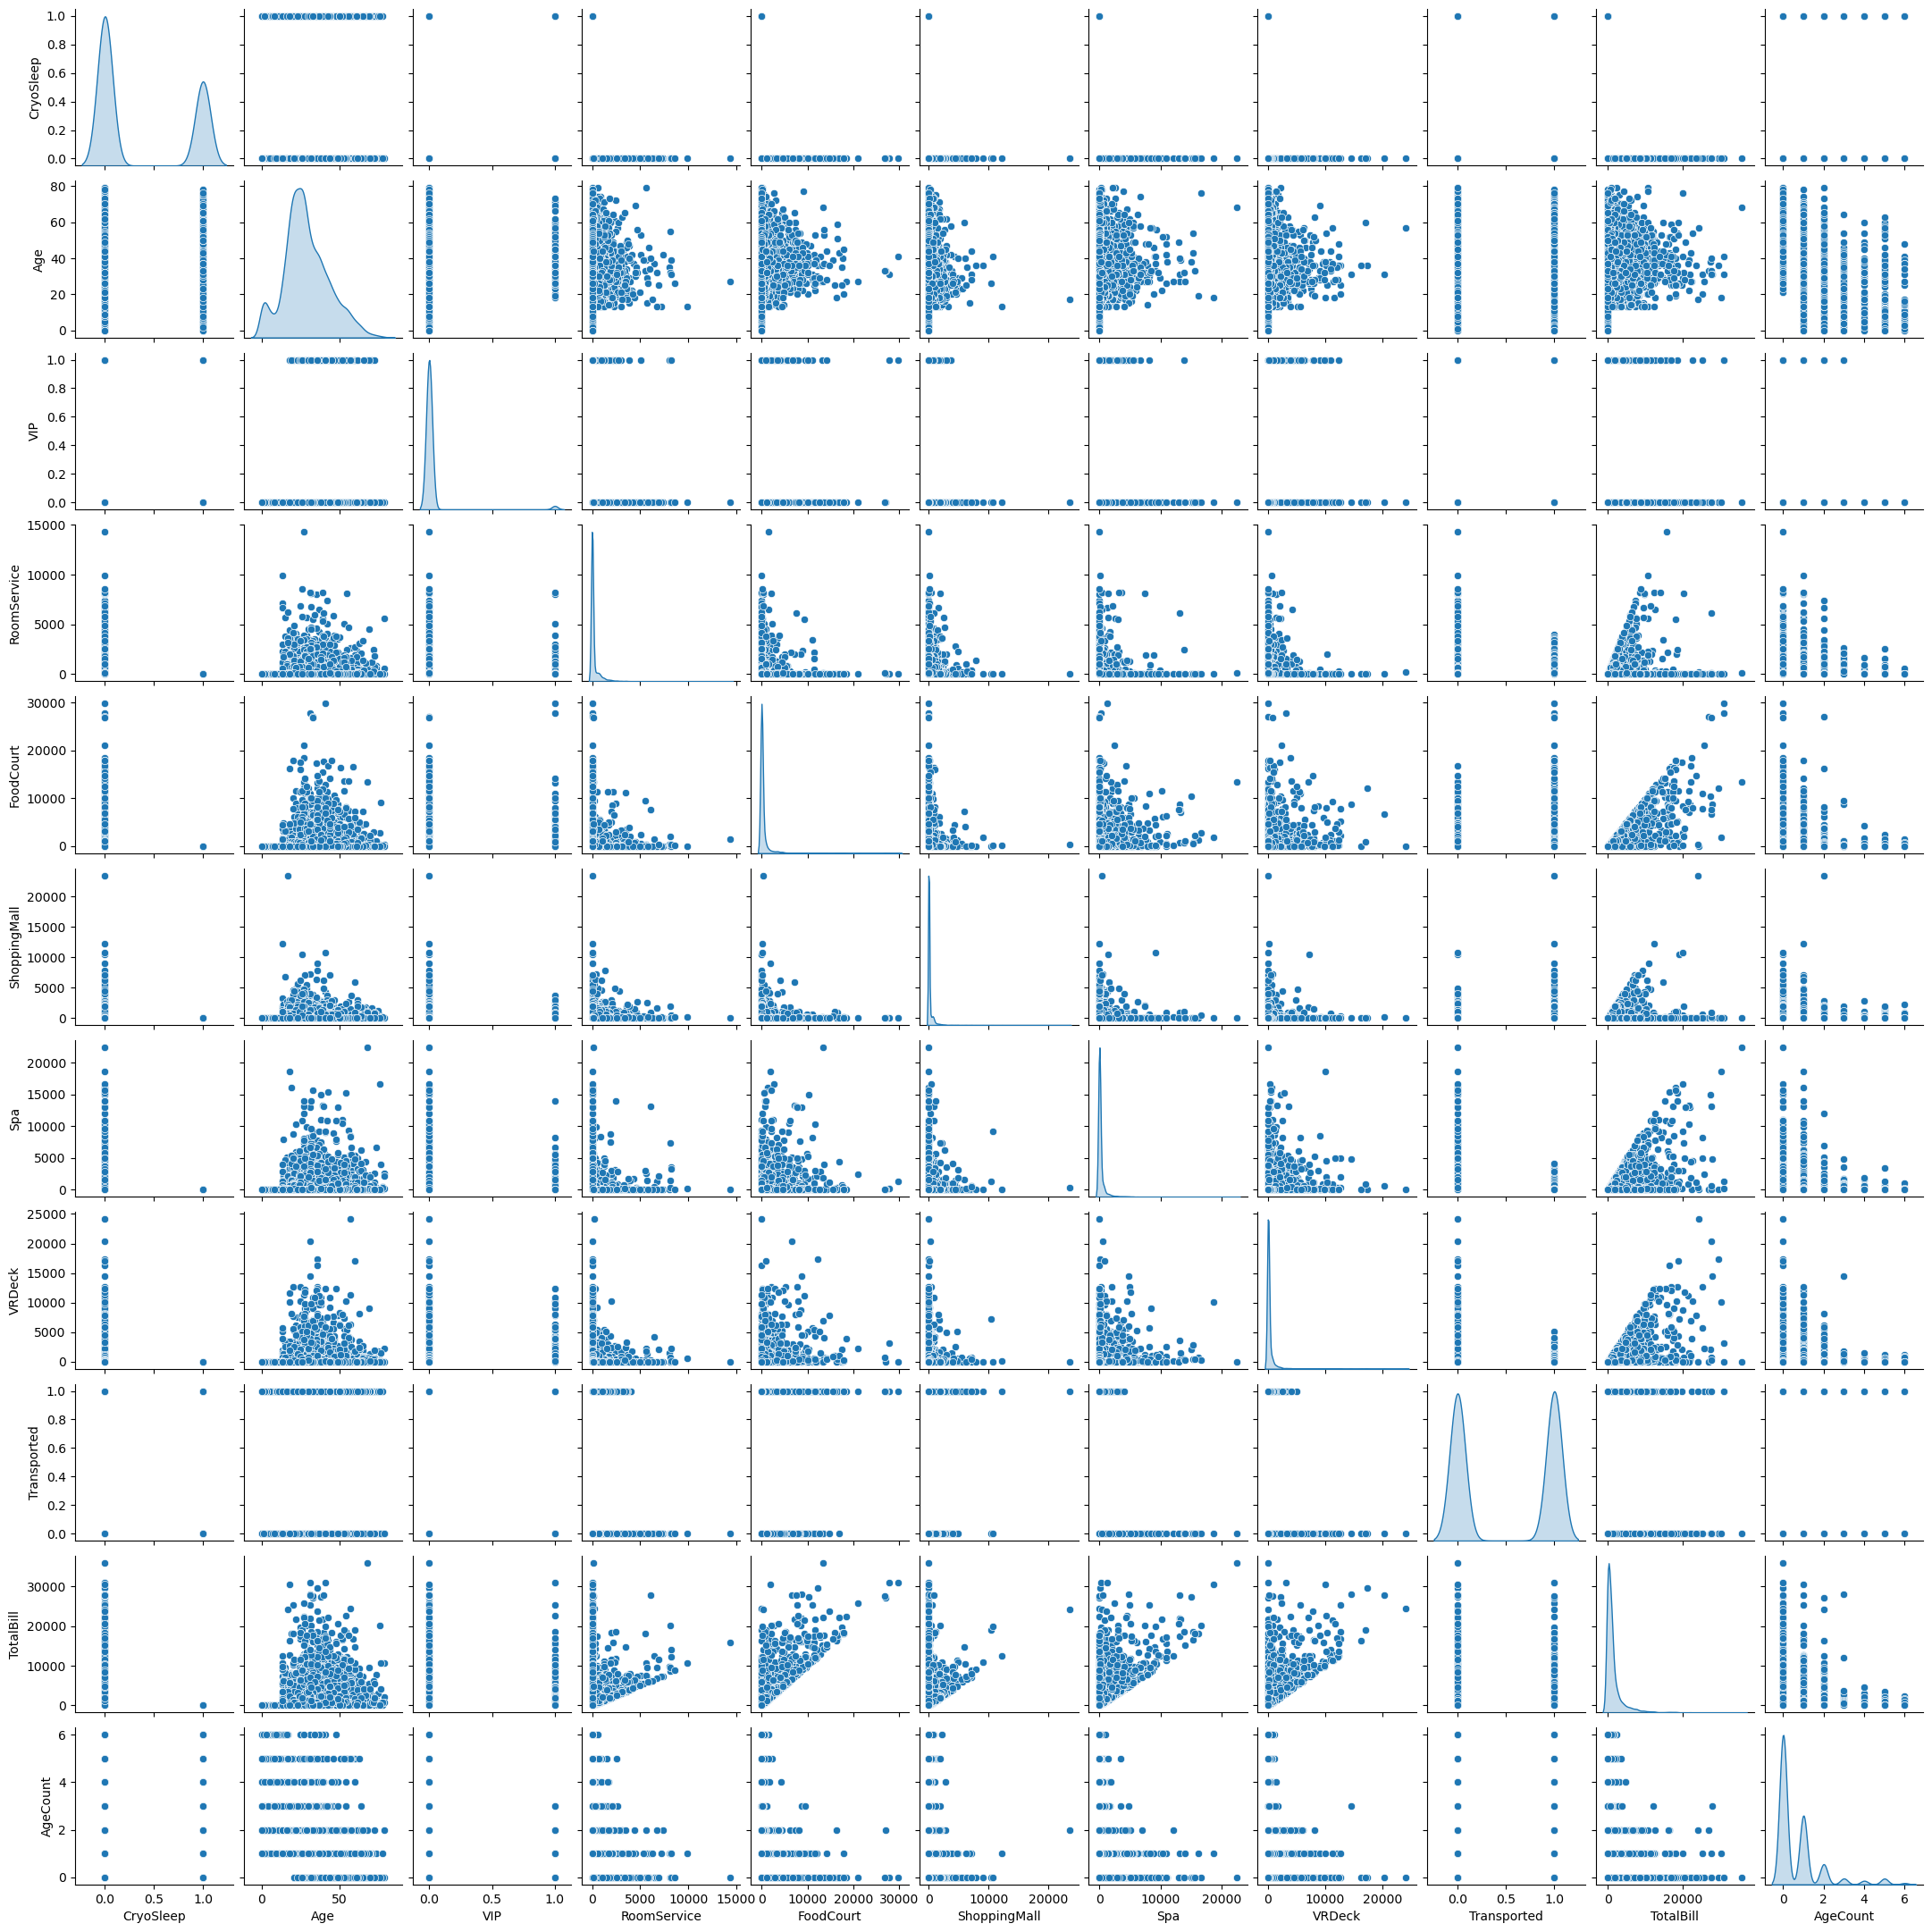

In [51]:
sns.pairplot(train.drop(columns=cat), height = 2 ,kind ='scatter',diag_kind='kde')

Корелляция численных столбцов

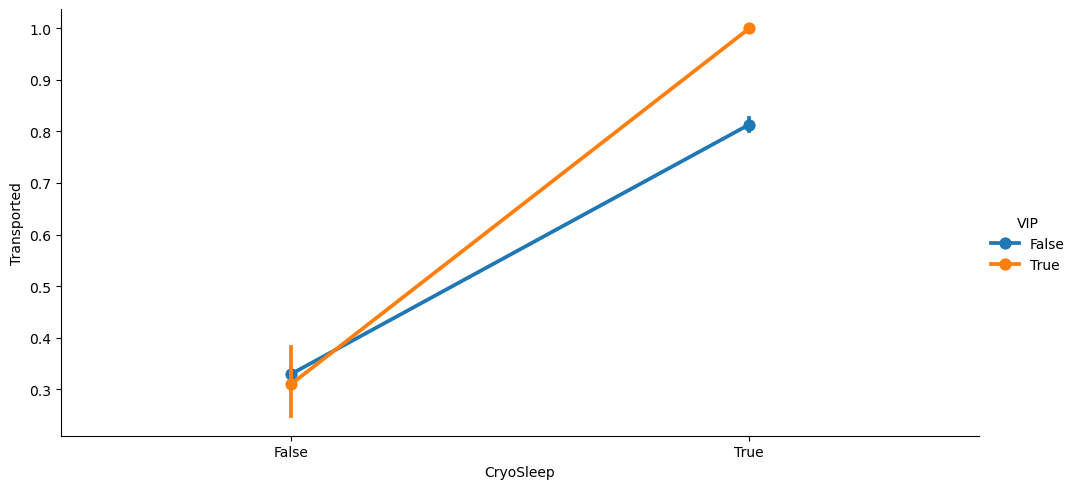

In [53]:

sns.catplot(x='CryoSleep', y='Transported',hue='VIP',aspect=2, data=train, kind='point')

Больше выживают те, кто в криосне

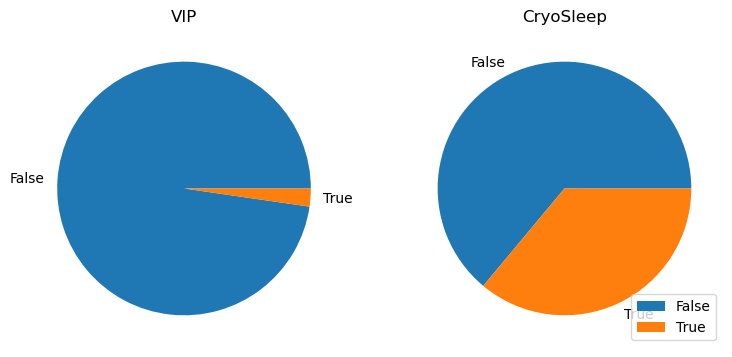

In [55]:
fig,axes = plt.subplots(1,2,figsize=(9,6))
for i,col in enumerate(['VIP','CryoSleep']):
    val = train[col].value_counts()
    axes[i].pie(val.values,labels=val.index,)
    axes[i].set_title(col)
plt.legend(loc='lower right')
plt.show()


<Axes: xlabel='CryoSleep'>

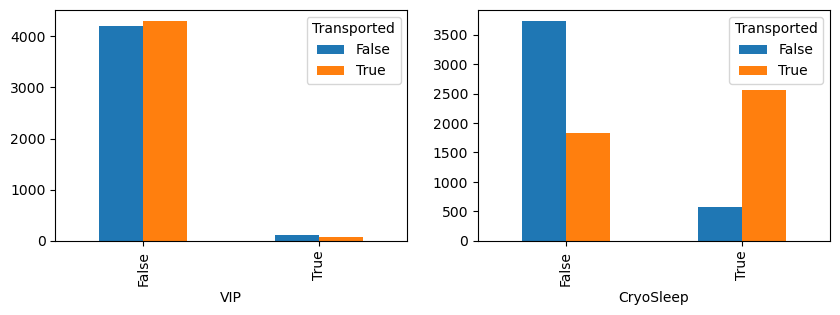

In [56]:
fig, axes = plt.subplots(1,2,figsize=(10,3))
cross_tab = pd.crosstab(train['VIP'],train['Transported'])
cross_tab.plot(kind='bar',ax=axes[0])
cross_tab = pd.crosstab(train['CryoSleep'],train['Transported'])
cross_tab.plot(kind='bar',ax=axes[1])

Формирую признаки и таргет, делаю полиномиальные фичи


In [58]:
X = train.drop(columns=['Transported','AgeCount'])
y = train['Transported']
poly = PolynomialFeatures(degree=3,include_bias=False)
le = LabelEncoder()
y = le.fit_transform(y)

Стандартизирую численные признаки, кодирую котегориальные

In [60]:
prepr = ColumnTransformer(transformers=[('n',StandardScaler(),['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalBill']),('b','passthrough',['CryoSleep','VIP']),('c',OrdinalEncoder(),['HomePlanet','Destination','PassengerId','PassengerGroup','Num','AgeGroup','Side','Deck'])])

Модель Градиентного бустинга

In [62]:
def pipe1(model0,X_t,y_t):
    pipeline = Pipeline([('prepr',prepr),('poly',poly),('model',model0)])
    pipeline.fit(X_t,y_t)
    return pipeline

def pipe(model0,X_t,y_t):
    pipeline = make_pipeline(StandardScaler(),model0)
    pipeline.fit(X_t,y_t)
    return pipeline

Обучаю модель

С тестовой выборкой все тоже самое, что и с тренировочной

In [65]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [66]:
model = lgb.LGBMClassifier(n_estimators=195,learning_rate=0.05,max_depth=9,num_leaves=31,reg_alpha=0.1,reg_lambda=0.1,min_child_samples=20,min_split_gain=0.001,subsample=0.8,colsample_bytree=0.8,n_jobs=-1,verbosity=-1)
pp = pipe1(model,X_train,y_train)
y_t = pp.predict(X_test)
accuracy_score(y_t,y_test)

0.8079355951696378

In [67]:
def feature_imp(df):
    X = df.drop('Transported', axis=1)
    y = df['Transported']
    
    X = pd.get_dummies(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    
    # Logistic Regression
    model1 = LogisticRegression(max_iter=1000)
    pipeline_lr = pipe(model1, X_train, y_train)
    coef_lr = pipeline_lr[1].coef_[0] 
    acc_train_lr = accuracy_score(y_true=y_train, y_pred=pipeline_lr.predict(X_train))
    acc_test_lr = accuracy_score(y_true=y_test, y_pred=pipeline_lr.predict(X_test))
    label_lr = f'LR (train={acc_train_lr:.2%}, test={acc_test_lr:.2%})'
    
    # Random Forest
    model2 = RandomForestClassifier(random_state=0)
    pipeline_rf = pipe(model2, X_train, y_train)
    coef_rf = pipeline_rf[1].feature_importances_ # Правильный доступ
    acc_train_rf = accuracy_score(y_true=y_train, y_pred=pipeline_rf.predict(X_train))
    acc_test_rf = accuracy_score(y_true=y_test, y_pred=pipeline_rf.predict(X_test))
    label_rf = f'RF (train={acc_train_rf:.2%}, test={acc_test_rf:.2%})'

    # LightGBM
    model3 = lgb.LGBMClassifier(n_estimators=195,learning_rate=0.05,max_depth=9,num_leaves=31,reg_alpha=0.1,reg_lambda=0.1,min_child_samples=20,min_split_gain=0.001,subsample=0.8,colsample_bytree=0.8,n_jobs=-1,verbosity=-1,random_state=0)
    pipeline_lgb = pipe(model3, X_train, y_train)
    coef_lgb = pipeline_lgb[1].feature_importances_
    acc_train_lgb = accuracy_score(y_true=y_train, y_pred=pipeline_lgb.predict(X_train))
    acc_test_lgb = accuracy_score(y_true=y_test, y_pred=pipeline_lgb.predict(X_test))
    label_lgb = f'LGB (train={acc_train_lgb:.2%}, test={acc_test_lgb:.2%})'
    
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'LR': np.abs(coef_lr),
        'RF': coef_rf,
        'LightBoost': coef_lgb
    })
    
    feature_importances = feature_importances.sort_values(by='LightBoost', ascending=False)
    
    sc = MaxAbsScaler()
    feature_importances['LR_scaled'] = sc.fit_transform(feature_importances[['LR']])
    feature_importances['RF_scaled'] = sc.fit_transform(feature_importances[['RF']])
    feature_importances['LightBoost_scaled'] = sc.fit_transform(feature_importances[['LightBoost']])
    plt.figure(figsize=(12, 8))
    top_features = feature_importances.head(30)
    
    x = np.arange(len(top_features))
    width = 0.25
    
    plt.barh(x - width, top_features['LR_scaled'], height=width, label=label_lr, alpha=0.7)
    plt.barh(x, top_features['RF_scaled'], height=width, label=label_rf, alpha=0.7)
    plt.barh(x + width, top_features['LightBoost_scaled'], height=width, label=label_lgb, alpha=0.7)
    
    plt.ylabel('Features')
    plt.xlabel('Scaled Importance')
    plt.title('Feature Importance Comparison')
    plt.yticks(x, top_features['Feature'])
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(feature_importances[['Feature', 'LR', 'RF', 'LightBoost']].head(10))
    
    return ([acc_train_lr, acc_train_rf, acc_train_lgb], [acc_test_lr, acc_test_rf, acc_test_lgb])


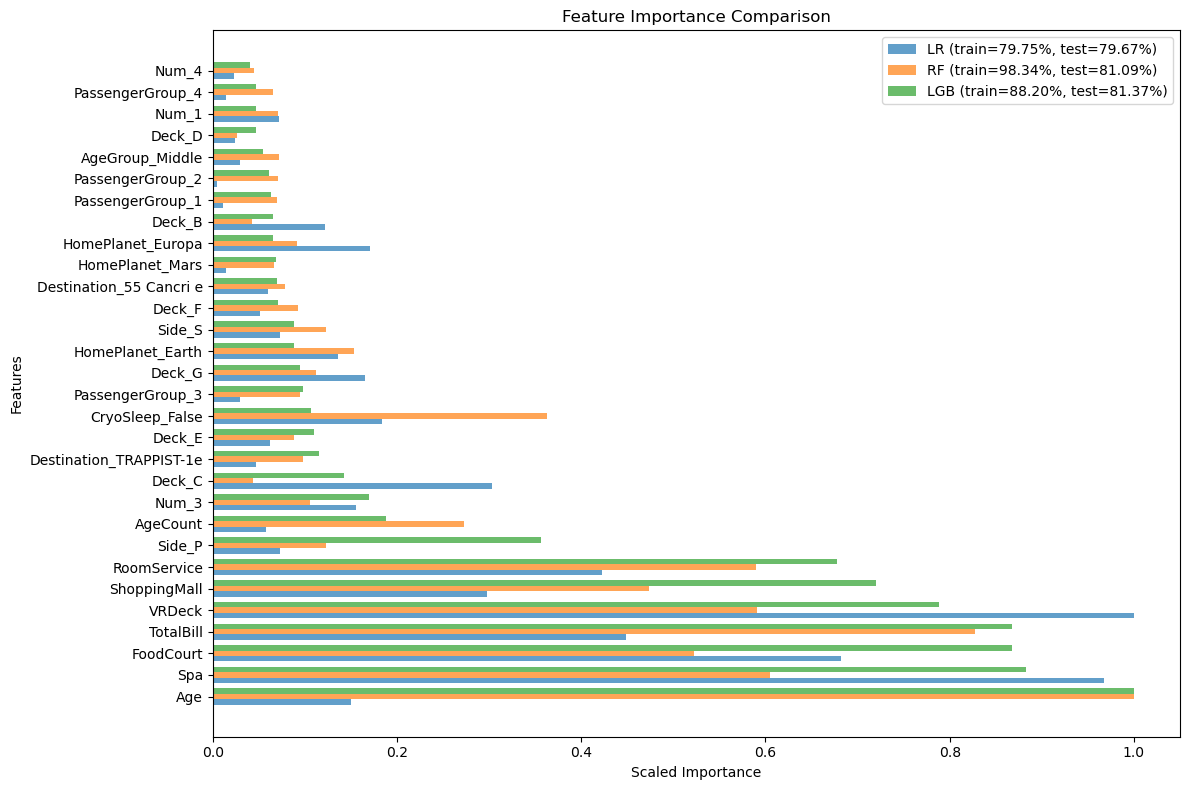

         Feature        LR        RF  LightBoost
0            Age  0.286645  0.126870         701
5            Spa  1.849380  0.076748         619
3      FoodCourt  1.303966  0.066229         608
7      TotalBill  0.858443  0.105000         608
6         VRDeck  1.911401  0.074903         553
4   ShoppingMall  0.568904  0.060095         505
2    RoomService  0.807163  0.074797         475
38        Side_P  0.139363  0.015646         250
8       AgeCount  0.111307  0.034572         132
35         Num_3  0.296187  0.013364         119


([0.7975149562816383, 0.9834330418775886, 0.882037122258015],
 [0.796688132474701, 0.8109475620975161, 0.8137074517019319])

In [68]:
feature_imp(train)